# Read a sw_tint and do peakfinding on it.

[08-Apr-25 16:34:22] INFO: Loading mms1_edp_scpot_fast_l2...
[08-Apr-25 16:34:23] INFO: Loading mms3_dsp_epsd_omni...
/homelocal/atlass/.venv/lib/python3.12/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


Frequency range between [5888.0, 80000.0] at indices [51, 81]
['2021-11-28T12:17:25.000000000', '2021-11-28T14:02:35.000000000']


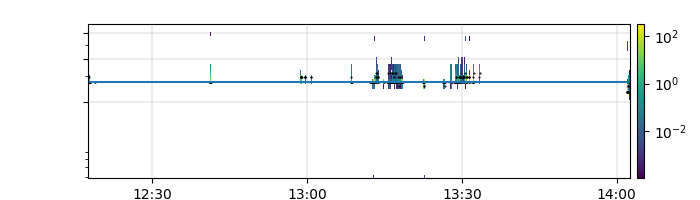

In [158]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2
import numpy as np
from pyrfu.plot import plot_line, plot_spectr
from pyrfu import mms
import matplotlib.pyplot as plt
from epsd_peakfinder import epsd_peakfinder
from scipy.ndimage import uniform_filter1d,gaussian_filter1d

h = np.genfromtxt('sw_tints/compiled_sw_tints.csv', dtype=str,delimiter=',', skip_header=1)
j = h[np.random.randint(0, len(h))]
tint = [str(j[0]), str(j[1])]
ic = j[2]
# ic = 1
# tint = ['2018-04-02T23:12:45.752031977', '2018-04-03T02:44:09.883192811']
# tint = ['2024-05-03T17:00:00.000000000', '2024-05-04T08:40:00.00'] # BENCHMARK
vsc = mms.get_data("v_edp_fast_l2", tint, 1)
epsd = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint)

# Convert spectral power from (V/m)^{2}/Hz -> (mV/m)^{2}/Hz
epsd.data *= 1e6
epsd.attrs['UNITS'] = '(mV/m)^{2}/Hz'

plt.close('all')
fig, ax = plt.subplots(1, figsize=(7, 2))

epsd_cut, f_peaks, median_peak = epsd_peakfinder(epsd, 1e-4)
print(tint)
if f_peaks is None:
    print('No peaks found')

else:
    ax_s, ax_c = plot_spectr(ax, epsd_cut, clim='auto', yscale='log', cscale='log')
    plot_line(ax, f_peaks, linestyle='none', marker='.', color='black', markersize=1)
    ax.axhline(median_peak, 0, 1)




# Feed peaks into SCpot calibration

[08-Apr-25 16:34:24] INFO: Loading mms3_edp_scpot_fast_l2...


[08-Apr-25 16:34:25] INFO: Using averages in resample


Method 2
Fitted ne peaks to spacecraft potential with 53.14414037450549 2.7914917403561037
Fitted ne peaks to spacecraft potential with 47.703434631048694 2.9625108639472346


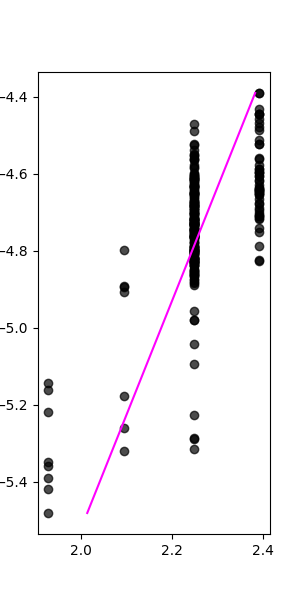

In [159]:

import numpy as np
import xarray as xr
from scipy import optimize

from pyrfu import pyrf
from ne2fpe import ne2fpe

# Fitting formula from Khotyaintsev 2021 using RPW
def _vsc2ne_fit(vsc, ne):
    
    log_ne = np.log(ne)
    
    fit_results = np.polyfit(vsc, log_ne, deg=1, cov=True)
    b, a = fit_results[0]
    covar = fit_results[1]

    N0_fit = np.exp(a)
    beta_fit = -1/b
    print('Fitted ne peaks to spacecraft potential with', N0_fit, beta_fit)

    return N0_fit, beta_fit, covar


def fpeaks_scpot2ne(vsc_data, f_peaks, method=2, coeffs=None):
    # Convert fpe [Hz] --> ne [cm^-3]
    ne_peaks = ne2fpe(f_peaks, inverse=True)
    
    if vsc_data.size != ne_peaks.size:
        raise IndexError('Peaks and Vsc points are not 1-to-1')
    
    
    if method == 1:
        # Clean fit of both parameters with no fallback
        print('Method 1')

        
    elif method == 2:
        # Fit both paramters and use beta_fallback from <Vsc> if fit result "goes crazy"
        print('Method 2')
        
        N0, beta, covar = _vsc2ne_fit(vsc_data, ne_peaks)
        
        
    elif method == 3:
        # Only fit N0
        print('Method 3')
        
    # Determine outliers
    ne_bestfit = N0 * np.exp(-vsc_data / beta) 
    residuals = ne_bestfit.data - ne_peaks.data
    std = (residuals - np.median(residuals)) / np.std(residuals)
    outliers_idxs = np.abs(std) > 2.5
    
    ne_peaks_valid = ne_peaks[~outliers_idxs]
    vsc_data_valid = vsc_data[~outliers_idxs]
    
    N0_2, beta_2, covar_2 = _vsc2ne_fit(vsc_data_valid, ne_peaks_valid)
    
    

    return N0_2, beta_2, covar_2, outliers_idxs

vsc_ = mms.get_data('v_edp_fast_l2', tint, ic)
vsc = vsc_.drop_duplicates(dim='time')


vsc_rs = pyrf.resample(vsc, f_peaks.time, f_s=pyrf.calc_fs(f_peaks))

valid_idxs = np.isfinite(vsc_rs.data) & np.isfinite(f_peaks.data)
vsc_tofit = vsc_rs[valid_idxs]
f_peaks_tofit = f_peaks[valid_idxs]



N0, beta, covar, outliers_idxs = fpeaks_scpot2ne(vsc_tofit, f_peaks_tofit)
vsc_no_out = vsc_tofit[~outliers_idxs]
f_peaks_no_out = f_peaks_tofit[~outliers_idxs]



vmin, vmax = np.min(vsc_tofit), np.max(vsc_tofit)
# v_axis = np.arange(vmin, vmax, pyrf.calc_dt(vsc_tofit))
v_axis = np.unique(-vsc_no_out.data)

ne_fit = N0 * np.exp(v_axis / beta)

fig, ax = plt.subplots(1, figsize=(3, 6))
ne_peaks_tofit = ne2fpe(f_peaks_no_out, inverse=True)
ax.scatter(np.log(ne_peaks_tofit), -vsc_no_out, color='black', alpha=0.7)
ax.plot(np.log(ne_fit), v_axis, color='magenta')
